# Seasonal PPS Variation

In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nba_api.stats.endpoints.playerdashptshots import PlayerDashPtShots

## Acquiring and Merging Data
Shooting data from shots taken with closest defender distance.

In [3]:
def shooting_by_seasons(seasons, df_select):
    '''
    Parameters
    ----------
    seasons: List of seasons (strings)
    df_select: DataFrame to return (int)
    '''
    results = []
    for season in seasons:
        temp = PlayerDashPtShots(team_id=0, player_id=0, season=season).get_data_frames()[df_select]
        temp['season'] = season
        results.append(temp)
    
    df = pd.concat(results)
    return df

### Note:
Data is available starting from the 2013-14 season

In [4]:
# Get all available data
seasons = [
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20',
]

In [5]:
df_all = shooting_by_seasons(seasons, 4) # All shots
df_ten = shooting_by_seasons(seasons, 5) # >=10ft shots

In [6]:
# Rename columns and only keep relevent data
df_all.rename(
    columns={
        'PLAYER_ID': 'player_id',
        'PLAYER_NAME_LAST_FIRST': 'last_first',
        'CLOSE_DEF_DIST_RANGE': 'closest_def',
    },
    inplace=True
)

df1 = df_all[[
    'player_id',
    'last_first',
    'season',
    'GP',
    'closest_def',
    'FG2M',
    'FG2A',
    'FG3M',
    'FG3A'
]]

df_ten.rename(
    columns={
        'PLAYER_ID': 'player_id',
        'PLAYER_NAME_LAST_FIRST': 'last_first',
        'CLOSE_DEF_DIST_RANGE': 'closest_def',
        'FG2M': 'FG2>=10M',
        'FG2A': 'FG2>=10A',
    },
    inplace=True
)

df2 = df_ten[[
    'player_id',
    'last_first',
    'season',
    'GP',
    'closest_def',
    'FG2>=10M',
    'FG2>=10A',
]]

In [7]:
# Merge DataFrames
df = df1.merge(df2, on=['player_id', 'last_first', 'season', 'GP', 'closest_def'], how='left')

# Convert NaN shooting values to 0
df['FG2>=10M'] = np.where(df['FG2>=10M'].isna(), 0, df['FG2>=10M'])
df['FG2>=10A'] = np.where(df['FG2>=10A'].isna(), 0, df['FG2>=10A'])

In [8]:
df.isna().sum()

player_id      0
last_first     0
season         0
GP             0
closest_def    0
FG2M           0
FG2A           0
FG3M           0
FG3A           0
FG2>=10M       0
FG2>=10A       0
dtype: int64

In [9]:
# Total players
len(df['last_first'].unique())

1084

## Feature Engineering
- 2 point shots separated into shots less than 10ft and greater or equal to 10ft
- Average points per shot for the 3 distinct zones

In [10]:
# Engineer FG2<10 columns
df['FG2<10M'] = df['FG2M'] - df['FG2>=10M']
df['FG2<10A'] = df['FG2A'] - df['FG2>=10A']

In [11]:
df.drop(columns=['FG2M', 'FG2A'], inplace=True)

In [12]:
# Set GP (games played) type to int for groupby aggregate functions
df['GP'] = df['GP'].astype('int')

In [13]:
a = df.groupby('season')['FG3M', 'FG3A', 'FG2>=10M', 'FG2>=10A', 'FG2<10M', 'FG2<10A'].sum().reset_index()
b = df.groupby('season')['GP'].mean().reset_index()

# Make shooting percentages features for different shot zones
a['3PCT'] = a['FG3M'] / a['FG3A']
a['midPCT'] = a['FG2>=10M'] / a['FG2>=10A']
a['shortPCT'] = a['FG2<10M'] / a['FG2<10A']

# Add games played by season
a = a.merge(b, on='season')

# Make points per shot features
a['3/G'] = a['FG3A'] / a['GP']
a['mid/G'] = a['FG2>=10A'] / a['GP']
a['short/G'] = a['FG2<10A'] / a['GP']
a['3PPS'] = a['3PCT'] * 3
a['shortPPS'] = a['shortPCT'] * 2
a['midPPS'] = a['midPCT'] * 2

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


### Note:
- A normal NBA season has a total of 1230 games played.  Data is not available for games played in arenas without SportsVue cameras (in each season, several regular season games are played abroad or in neutral sites).

In [14]:
a

,season,FG3M,FG3A,FG2>=10M,FG2>=10A,FG2<10M,FG2<10A,3PCT,midPCT,shortPCT,GP,3/G,mid/G,short/G,3PPS,shortPPS,midPPS
0,2013-14,18962,52346,24150.0,59244.0,49281.0,80193.0,0.362244,0.407636,0.614530,1226,42.696574,48.323002,65.410277,1.086731,1.229060,0.815272
1,2014-15,19247,54588,23768.0,58168.0,49023.0,80493.0,0.352587,0.408610,0.609034,1227,44.488998,47.406683,65.601467,1.057760,1.218069,0.817219
2,2015-16,20914,58751,23183.0,56308.0,49795.0,80430.0,0.355977,0.411718,0.619110,1228,47.842834,45.853420,65.496743,1.067931,1.238220,0.823435
3,2016-17,23656,65747,21678.0,52033.0,50338.0,79900.0,0.359803,0.416620,0.630013,1226,53.627243,42.441272,65.171289,1.079410,1.260025,0.833240
4,2017-18,25585,70209,19505.0,46934.0,51546.0,81049.0,0.364412,0.415584,0.635986,1222,57.454173,38.407529,66.324877,1.093236,1.271971,0.831167
5,2018-19,27822,78395,17583.0,43194.0,55116.0,96689.0,0.354895,0.407070,0.570034,1226,63.943719,35.231648,78.865416,1.064685,1.140068,0.814141
6,2019-20,25671,71711,14140.0,34174.0,46046.0,80560.0,0.357979,0.413765,0.571574,1053,68.101614,32.453941,76.505223,1.073936,1.143148,0.827530


In [15]:
a.set_index('season', inplace=True)

In [16]:
pps = a[['3PPS', 'midPPS', 'shortPPS']]
atts = a[['3/G', 'mid/G', 'short/G']]

In [17]:
pps

,3PPS,midPPS,shortPPS
season,,,
2013-14,1.086731,0.815272,1.229060
2014-15,1.057760,0.817219,1.218069
2015-16,1.067931,0.823435,1.238220
2016-17,1.079410,0.833240,1.260025
2017-18,1.093236,0.831167,1.271971
2018-19,1.064685,0.814141,1.140068
2019-20,1.073936,0.827530,1.143148


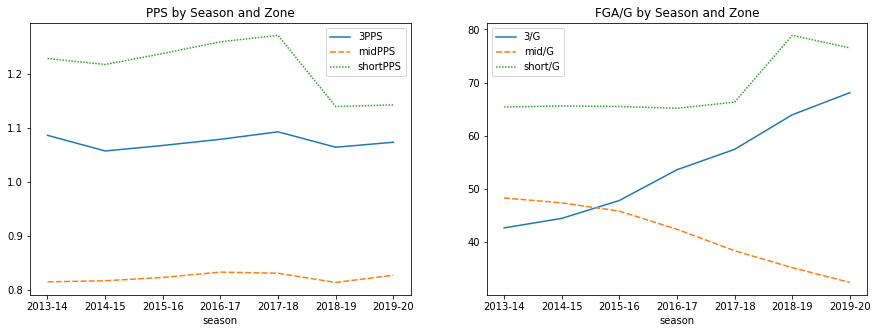

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.lineplot(data=pps, ax=axs[0]).set_title('PPS by Season and Zone')
sns.lineplot(data=atts, ax=axs[1]).set_title('FGA/G by Season and Zone')
plt.show()

### Notes:
- Starting in the 2018-19 season, the shot clock reset to a 14 second shot clock instead of a 24 second shot clock.  This may have lead to more tightly guarded shots leading to lower FG% and PPS.
- Further look: A/G for shot types by closest defender distance. 

In [19]:
# Group season and closest defender, merge games played
c = df.groupby(['season', 'closest_def'])['FG3A', 'FG2>=10A', 'FG2<10A'].sum().reset_index()
d = df.groupby(['season', 'closest_def'])['GP'].mean().reset_index()
c = c.merge(d, on=['season', 'closest_def'])

# Create attempts/game feature
c['3A/G'] = c['FG3A'] / c['GP']
c['midA/G'] = c['FG2>=10A'] / c['GP']
c['shortA/G'] = c['FG2<10A'] / c['GP']

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [20]:
# Keep relevent data
c = c[['season', 'closest_def', '3A/G', 'midA/G', 'shortA/G']]
c.head()

,season,closest_def,3A/G,midA/G,shortA/G
0,2013-14,0-2 Feet - Very Tight,0.637847,2.956770,24.637847
1,2013-14,2-4 Feet - Tight,5.281403,15.937194,30.188418
2,2013-14,4-6 Feet - Open,15.400489,18.767537,8.049755
3,2013-14,6+ Feet - Wide Open,21.376835,10.661501,2.534258
4,2014-15,0-2 Feet - Very Tight,0.661777,2.828851,24.048900


In [21]:
# Convert data from wide to long format
atts_def = pd.melt(
    c,
    id_vars=['season', 'closest_def'],
    value_vars=['3A/G', 'midA/G', 'shortA/G'],
    var_name='shot_type',
    value_name='A/G',
)

# Rename shot types
atts_def['shot_type'] = atts_def['shot_type'].map({'3A/G': 'three', 'midA/G': 'midrange', 'shortA/G': 'short'})
atts_def.head()

,season,closest_def,shot_type,A/G
0,2013-14,0-2 Feet - Very Tight,three,0.637847
1,2013-14,2-4 Feet - Tight,three,5.281403
2,2013-14,4-6 Feet - Open,three,15.400489
3,2013-14,6+ Feet - Wide Open,three,21.376835
4,2014-15,0-2 Feet - Very Tight,three,0.661777


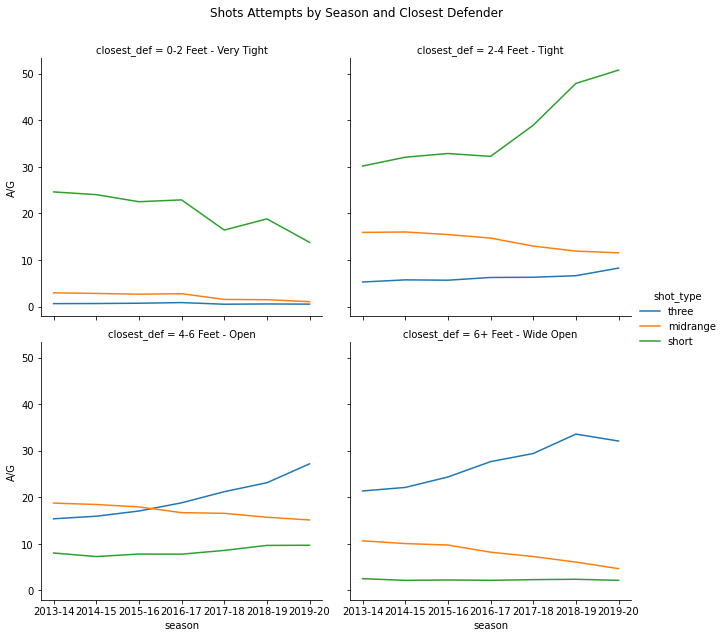

In [56]:
g = sns.FacetGrid(atts_def, col='closest_def', col_wrap=2, hue='shot_type', height=4.5)
g.map(sns.lineplot, 'season', 'A/G')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Shots Attempts by Season and Closest Defender')
plt.show()

### Notes:
- There has been an increasing number of tightly guarded short 2s and 3s; however, there has been a drastically increasing number of open to wide open 3s being attempted.  The previously observed decrease in PPS for close range shots may be a result of increased defensive presence closer to the basket or offenses forcing shots close to the basket regardless of defensive pressure.
- In the ```pps_init_eda.ipynb``` notebook the analysis of PPS by defender distance between midrange shots and 3-point shots indicated that PPS scales linearly with closest defender distance (greater closest defender distance results in greater PPS).  With this in mind, a substantial increase in open to wide open 3-point shot attempts should result in an increase in PPS for all 3-point attempts, this does not appear to be the case.
- Further look: which players are taking the shots, i.e. are teams making bad 3-point shooters take more 3-point shots because data tells them 3-point shots are better gambles with respect to PPS?

## EDA and Insights
### The subset of players who should take more midrange shots
- Are bad 3-point shooters taking more 3-pointers than they should?  As defined by 3-point shooters with lower 3-point PPS than midrange PPS.

In [312]:
# Create subset of shooters that have lower 3-point PPS than midrange PPS in a season
df2 = df.groupby(['last_first', 'season'])['FG2<10M', 'FG2<10A','FG2>=10M', 'FG2>=10A', 'FG3M', 'FG3A'].sum().reset_index()
df2 = df2.loc[(df2['FG3A'] > 0) & (df2['FG2>=10A'] > 0)]
df2 = df2.loc[(3 * df2['FG3M'] / df2['FG3A']) < (2 * df2['FG2>=10M'] / df2['FG2>=10A'])]

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [313]:
df2.head()

,last_first,season,FG2<10M,FG2<10A,FG2>=10M,FG2>=10A,FG3M,FG3A
2,"Abrines, Alex",2018-19,10.0,20.0,5.0,10.0,41,127
11,"Adams, Jordan",2015-16,1.0,2.0,1.0,3.0,0,1
13,"Adams, Steven",2014-15,209.0,351.0,5.0,15.0,0,2
15,"Adams, Steven",2016-17,353.0,554.0,21.0,56.0,0,1
16,"Adams, Steven",2017-18,419.0,604.0,23.0,46.0,0,2


In [314]:
# Number of players in 2013-14 to 2019-20 seasons with 3-point PPS < midrange PPS
len(df2['last_first'].unique())

421

In [315]:
# Number of 3-point attempts per season
data = df2.groupby('season')['FG2<10A', 'FG2>=10A', 'FG3A'].sum().reset_index()

# Engineer features for attempts per game
data = data.merge(df.groupby('season')['GP'].mean().reset_index(), on='season')
data['3/G'] = data['FG3A'] / data['GP']
data['midrange/G'] = data['FG2>=10A'] / data['GP']
data['short/G'] = data['FG2<10A'] / data['GP']
data = data[['season', '3/G', 'midrange/G', 'short/G']]

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [316]:
# Convert data from wide to long
data = pd.melt(
    data,
    id_vars='season',
    value_vars=['3/G', 'midrange/G', 'short/G'],
    var_name='shot_type',
    value_name='A/G'
)

# Rename shot types
data['shot_type'] = data['shot_type'].map({'3/G': '3-pointer', 'midrange/G': 'midrange 2', 'short/G': 'short 2'})

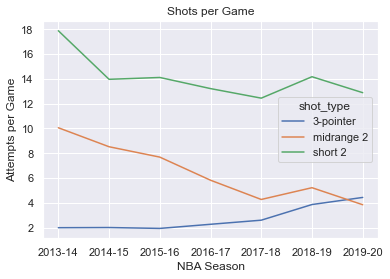

In [317]:
sns.lineplot(data=data, x='season', y='A/G', hue='shot_type')
plt.title('Shots per Game')
plt.xlabel('NBA Season')
plt.ylabel('Attempts per Game')
plt.show()

In [319]:
# Overall PPS by shot over multiple seasons
three_pps = df2['FG3M'].sum() / df2['FG3A'].sum() * 3
mid_pps = df2['FG2>=10M'].sum() / df2['FG2>=10A'].sum() * 2
short_pps = df2['FG2<10M'].sum() / df2['FG2<10A'].sum() * 2
print('3-point PPS:', three_pps)
print('Midrange PPS:', mid_pps)
print('Short 2 PPS:', short_pps)

3-point PPS: 0.7892642377078174
Midrange PPS: 0.8491567316080256
Short 2 PPS: 1.2465410817593114


In [323]:
short_pps_sea = (2 * df2.groupby('season')['FG2<10M'].sum() /df2.groupby('season')['FG2<10A'].sum()).reset_index()
mid_pps_sea = (2 * df2.groupby('season')['FG2>=10M'].sum() / df2.groupby('season')['FG2>=10A'].sum()).reset_index()
three_pps_sea = (3 * df2.groupby('season')['FG3M'].sum() /df2.groupby('season')['FG3A'].sum()).reset_index()

In [324]:
data = pd.merge(short_pps_sea, mid_pps_sea, on='season')
data = pd.merge(data, three_pps_sea, on='season')

In [327]:
data.columns = ['season', 'short_PPS', 'mid_PPS', 'three_PPS']

In [328]:
data = pd.melt(
    data,
    id_vars='season',
    value_vars=['short_PPS', 'mid_PPS', 'three_PPS'],
    var_name='shot_type',
    value_name='PPS'
)

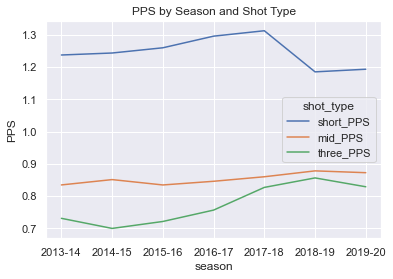

In [329]:
sns.lineplot(data=data, x='season', y='PPS', hue='shot_type')
plt.title('PPS by Season and Shot Type')
plt.show()

In [298]:
better_mid = list(df2['last_first'].unique())

In [300]:
df_subset = df.loc[df['last_first'].isin(better_mid)]

In [301]:
# Group season and closest defender, merge games played
c = df_subset.groupby(['season', 'closest_def'])['FG3A', 'FG2>=10A', 'FG2<10A'].sum().reset_index()
d = df_subset.groupby(['season', 'closest_def'])['GP'].mean().reset_index()
c = c.merge(d, on=['season', 'closest_def'])

# Create attempts/game feature
c['3A/G'] = c['FG3A'] / c['GP']
c['midA/G'] = c['FG2>=10A'] / c['GP']
c['shortA/G'] = c['FG2<10A'] / c['GP']

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [309]:
data = pd.melt(
    c,
    id_vars=['season', 'closest_def'],
    value_vars=['3A/G', 'midA/G', 'shortA/G'],
    var_name='shot_type',
    value_name='A/G',
)

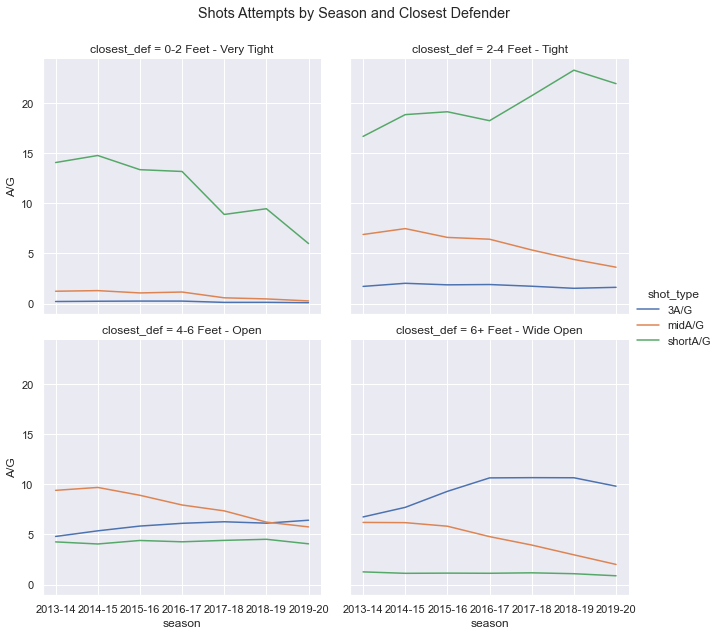

In [311]:
g = sns.FacetGrid(data, col='closest_def', col_wrap=2, hue='shot_type', height=4.5)
g.map(sns.lineplot, 'season', 'A/G')
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Shots Attempts by Season and Closest Defender')
plt.show()

### Notes:
- Shooters who are better midrange shooters than 3-point shooters (by PPS) have been taking an increasing number of 3s per game while taking fewer midrange 2 point shots.
- It appears the increase in open and wide open 3-point shots has increased the 3-pointer PPS for these players; however, the midrange 2 is still a better option for this subset of players.
- In this subset of players, there has been a marked decrease in PPS for short 2s (as with the entire set of NBA players).  The number of close range field goal attempts while being tightly guarded has gone up (defenses "packing the paint").

## Conclusions:
- There is a subset of players who are better midrange shooters than 3-point shooters with respect to points per shot (PPS).
- While the 3-point PPS for these players has increased by taking more open to wide open 3s, their 3-pointer PPS still lags behind their midrange PPS.
- Teams may benefit from allowing these players to take a few steps inside the 3 point arc before a shot.